# **Deceptive Comment Filtering on Social Media using ML**

In [195]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [196]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/Thesis')

# **Importing Libraries**

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import re, json, nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer

In [184]:
path ='/content/drive/My Drive/Colab Notebooks/Thesis/'

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# **Dataset Preparation**

In [198]:
data = pd.read_csv(path + 'dataset.csv')

print("Total Reviews:", len(data),
      "\nTotal Deceptive Comments:", len(data[data.label == 'deceptive']),
      "\nTotal Non-deceptive Comments:", len(data[data.label == 'non-deceptive']))

Total Reviews: 3500 
Total Deceptive Comments: 1998 
Total Non-deceptive Comments: 1502


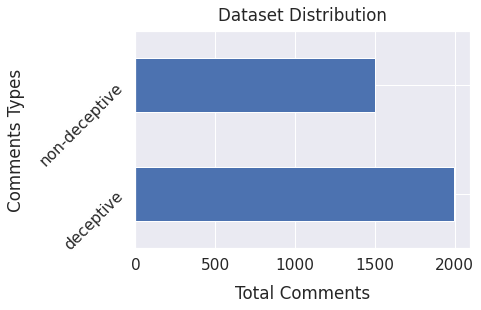

In [199]:
sns.set(font_scale=1.4)
data['label'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Total Comments", labelpad=12)
plt.ylabel("Comments Types", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [208]:
sample_data = [20, 100, 340, 550, 1100, 2100]

for i in sample_data:
      print(data.comments[i],'\n', 'Type:', data.label[i],'\n') 

ore batopar ar koyekota din apeksha kor desher manush tomader lengta kor pitabe 
 Type: deceptive 

era ekhon seheri paroti korote parena 
 Type: deceptive 

cheharata bikhyat pornostar minga kholifa sathe mil ache  dui diner boiragi vatere kozo onno khobis 
 Type: deceptive 

age aponar farmer shromikoder 4 maser beton porisheadh korun bradar 
 Type: deceptive 

tui shuzoorer bachcha ar konodin alor dekha pabina 
 Type: deceptive 

komentos ridar esosiyeshon theke komentos podote ese podoechi 
 Type: non-deceptive 



# **Removing Low Length Data**

In [209]:
# Length of each comments
data['length'] = data['comments'].apply(lambda x:len(x.split()))

# Remove the reviews with least words
dataset = data.loc[data.length > 2]
dataset = dataset.reset_index(drop = True)

print("After Cleaning:", "\nRemoved {} Small Comments".format(len(data)-len(dataset)),
      "\nTotal Reviews:", len(dataset))

After Cleaning: 
Removed 370 Small Comments 
Total Reviews: 3130


# **Dataset Summary**

In [210]:
def data_summary(dataset):
    """
    This function will print the summary of the reviews and words distribution in the dataset. 

    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """

    words = []
    u_words = []
    documents = []
    total_u_words = [word.strip().lower() for t in list(dataset.comments) for word in t.strip().split()]
    class_label= [k for k, v in dataset.label.value_counts().to_dict().items()]

    # Find word list
    for Label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.label==Label].comments) for word in t.strip().split()]
        counts = dict()

        for word in word_list:
            counts[word] = counts.get(word, 0) + 1
        
        # Sort the dictionary of word list  
        ordered = sorted(counts.items(), key=lambda item: item[1], reverse=True)
        
        # Documents per class
        documents.append(len(list(dataset[dataset.label==Label].comments)))
        
        # Total Word per class
        words.append(len(word_list))
        
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name:", Label)
        print("Total Documents: {}".format(len(list(dataset[dataset.label==Label].comments))))
        print("Total Words: {}".format(len(word_list))) 
        print("Total Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        
        for k,v in ordered[:10]:
            print("{}\t{}".format(k, v))
    
    print("Total Unique Words: {}".format(len(np.unique(total_u_words))))
    return documents, words, u_words, class_label

In [211]:
documents, words, u_words, class_names = data_summary(dataset)


Class Name: deceptive
Total Documents: 1831
Total Words: 37888
Total Unique Words:8668
Most Frequent Words:

na	798
kore	444
ki	412
ar	310
ei	276
bishwas	276
to	250
tar	225
aponi	220
ze	213

Class Name: non-deceptive
Total Documents: 1299
Total Words: 18401
Total Unique Words:5508
Most Frequent Words:

na	283
kore	175
allaho	172
ki	151
aponar	132
ei	131
o	124
jonyo	118
ar	117
vai	112
Total Unique Words: 11559


# **Dataset Summary Visualization**

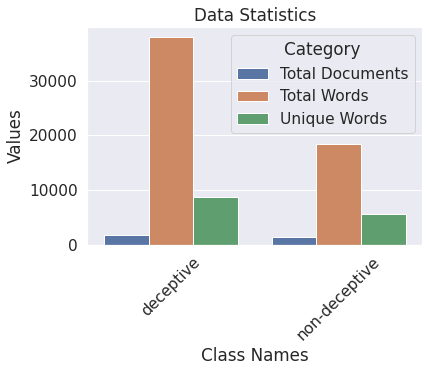

In [212]:
data_matrix = pd.DataFrame({'Total Documents': documents,
                            'Total Words': words,
                            'Unique Words': u_words,
                            'Class Names': class_names})

df = pd.melt(data_matrix, id_vars='Class Names', var_name="Category", value_name="Values")
plt.figure(figsize=(6, 4))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

# **Comment Lenght Distribution**

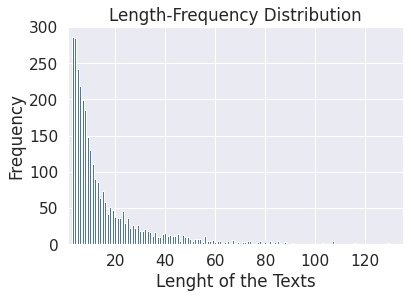

Maximum Length of a comment: 241
Minimum Length of a comment: 3
Average Length of a comment: 18.0


In [213]:
# Calculate the length of each of the comment
dataset['CommentLength'] = dataset.comments.apply(lambda x:len(x.split()))
frequency = dict()

for i in dataset.CommentLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color="b")
plt.xlim(1, 135)

# In this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()

print(f"Maximum Length of a comment: {max(dataset.CommentLength)}")
print(f"Minimum Length of a comment: {min(dataset.CommentLength)}")
print(f"Average Length of a comment: {round(np.mean(dataset.CommentLength), 0)}")

# **Model Building**

In [214]:
non_decep = dataset[dataset.label == 'non-deceptive']
deceptive = dataset[dataset.label == 'deceptive']

dataset = non_decep.append(deceptive, ignore_index=True)
dataset.label.value_counts()

deceptive        1831
non-deceptive    1299
Name: label, dtype: int64

# **Lable Encoding and Dataset Splitting**

In [217]:
# Label encoding
def label_encoding(sentiment,bool):
    """
    This function will return the encoded labels in array format. 

    Args:
        sentiment: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    
    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels)   # Converting into numpy array
    class_names =le.classes_            # Define the class names again
    
    if bool == True:
        print("\n\t\t\t - Label Encoding - ", "\nClass Names:", le.classes_)
        
        for i in sample_data:
            print(sentiment[i], ' ', encoded_labels[i], '\n')

    return labels

In [218]:
def dataset_split(feature_space,sentiment):
    """
    This function will return the splitted (80%-20%) feature vector . 

    Args:
        feature_space: calcuated feature vector (sparse matrix)
        sentiment: encoded lables (array) 
        
    Returns:
        x_train: training feature vector (sparse matrix)
        x_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    x_train, x_test, y_train, y_test = train_test_split(feature_space,sentiment,
                        train_size = 0.9, test_size = 0.1, random_state = 0)
    
    print("Feature Size:", x_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name", "\t\tSize")
    print("\t - - - \t\t - - - ")

    print("\tFull\t\t\t", feature_space.shape[0],
        "\n\tTraining\t\t", x_train.shape[0],
        "\n\tTest\t\t\t", x_test.shape[0])

    return x_train, x_test, y_train, y_test

In [219]:
dataset.cleaned = dataset.comments.apply(lambda x:x.replace('\n', ' '))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


# **Model Building Using Machine Learning**

# Feature Extraction using TF-IDF

In [220]:
def calc_gram_tfidf(comments, gram):
    """
    This function will return the tf-idf value of the respective gram features. 
    
    Args:
        reviews: a list of cleaned reviews   
        
    Returns:
        tfidf: a instance of TfidfVectorizer
        X : Unigram Feature Vector (sparse matrix)
    """

    tfidf = TfidfVectorizer(ngram_range=gram, use_idf=True, tokenizer=lambda x:x.split()) 
    X = tfidf.fit_transform(comments)
    
    return tfidf, X

In [221]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [222]:
def ml_models_defination(): 
    """
    This function consists the models defination for All gram Features
    
    Retuns:
        ml_models: list of models
        model_names: list of model_names
    
    """

    mnb_model = MultinomialNB(alpha=0.15)
    lsvm_model = SVC(kernel='linear', C=0.2, probability=True, random_state=0)
    ksvm_model = SVC(C=1000, kernel='rbf', probability=True, gamma=0.00015, random_state=0)
    model_names = ['Multinomial Naive Bayes', 'Linear SVM','Kernel SVM']

    ml_models = [mnb_model, lsvm_model, ksvm_model]
    return ml_models,model_names 

In [223]:
def model_performace(model, x_train, x_test, y_train, y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall.
    
    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
        
    Returns:
        my_dict: a dictionary of all the parameters for each models
    """

    my_dict = {}
    model.fit(x_train, y_train)
    
    # Prediction
    pred_y = model.predict(x_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100 
    my_dict['Precision'] = round(precision_score(y_test, pred_y),4)*100 
    my_dict['Recall'] = round(recall_score(y_test, pred_y),4)*100 
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y),4)*100 
    
    return my_dict  

In [224]:
def performance_table(performance_dict):
    """
    This function will create a dataframe of all the performance parameters.
    
    Args:
        performance_dict: a dictionary of all the parameters for each models
        
    Returns:
        performance_df: a dataframe
    """

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []

    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    # Create a dataframe
    model_names = ['MNB', 'Linear SVM', 'RBF SVM']
    performance_df = pd.DataFrame({'Accuracy': acc_list,'Precision': pr_list,
                                   'Recall': re_list,'F1 Score': f1_list,
                                   'Model Name': model_names})
    
    return performance_df

# **Model Training**

In [225]:
gram_names = ['Unigram', 'Bigram', 'Trigram']
ngrams = [(1,1), (1,2), (1,3)]

for i, gram in enumerate(ngrams):
    tfidf, feature = calc_gram_tfidf(dataset.comments, gram)
    labels = label_encoding(dataset.label, False)
    x_train, x_test, y_train, y_test = dataset_split(feature,labels) 
    ml_models, model_names = ml_models_defination()

    # Call model accuracy function and save the metrices into a dictionary
    accuracy = {f'{model_names[j]}': model_performace(model, x_train, x_test, y_train, y_test) for j, model in enumerate(ml_models)}
    
    # Save the performance parameter into json file
    with open(path + f'ml_performance_{gram_names[i]}.json', 'w') as f:
        json.dump(accuracy, f)

Feature Size: 11559

Dataset Distribution:

	Set Name 		Size
	 - - - 		 - - - 
	Full			 3130 
	Training		 2817 
	Test			 313
Feature Size: 53308

Dataset Distribution:

	Set Name 		Size
	 - - - 		 - - - 
	Full			 3130 
	Training		 2817 
	Test			 313
Feature Size: 100403

Dataset Distribution:

	Set Name 		Size
	 - - - 		 - - - 
	Full			 3130 
	Training		 2817 
	Test			 313


# **Performance Table**

In [226]:
# Load all the json files
gram_names = ['Unigram', 'Bigram', 'Trigram']

for gram in gram_names:
  accuracy = json.load(open(path + f'ml_performance_{gram}.json'))
  table = performance_table(accuracy)
  
  print(f"\n * * * Performace Table for {gram} feature * * * \n", table)
  print(f"\n * * * In case of {gram} feature * * * \n")
  
  print(f"Highest Accuracy achieved by {table['Model Name'][table.Accuracy.idxmax(axis=0)]} at = {max(table.Accuracy)}")
  print(f"Highest F1-Score achieved by {table['Model Name'][table['F1 Score'].idxmax(axis=0)]} at = {max(table['F1 Score'])}")
  print(f"Highest Precision Score achieved by {table['Model Name'][table['Precision'].idxmax(axis = 0)]} at = {max(table['Precision'])}")
  print(f"Highest Recall Score achieved by {table['Model Name'][table['Recall'].idxmax(axis=0)]} at = {max(table['Recall'])}")


 * * * Performace Table for Unigram feature * * * 
    Accuracy  Precision  Recall  F1 Score  Model Name
0     76.04      78.95   57.69     66.67         MNB
1     68.05      94.12   24.62     39.02  Linear SVM
2     73.48      89.83   40.77     56.08     RBF SVM

 * * * In case of Unigram feature * * * 

Highest Accuracy achieved by MNB at = 76.03999999999999
Highest F1-Score achieved by MNB at = 66.67
Highest Precision Score achieved by Linear SVM at = 94.12
Highest Recall Score achieved by MNB at = 57.69

 * * * Performace Table for Bigram feature * * * 
    Accuracy  Precision  Recall  F1 Score  Model Name
0     77.96      78.50   64.62     70.89         MNB
1     61.66      91.67    8.46     15.49  Linear SVM
2     66.13      92.86   20.00     32.91     RBF SVM

 * * * In case of Bigram feature * * * 

Highest Accuracy achieved by MNB at = 77.96
Highest F1-Score achieved by MNB at = 70.89
Highest Precision Score achieved by RBF SVM at = 92.86
Highest Recall Score achieved by MNB 

# **Performance Visualization**

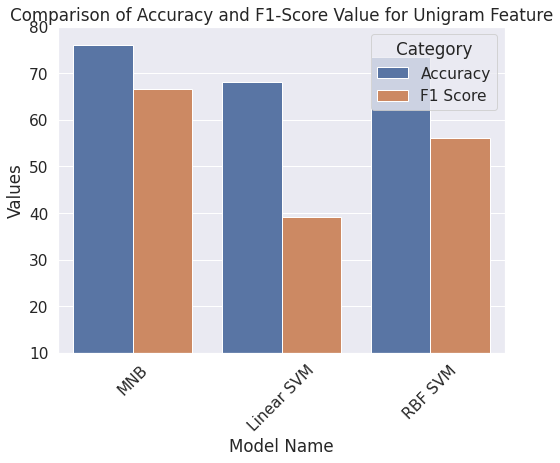

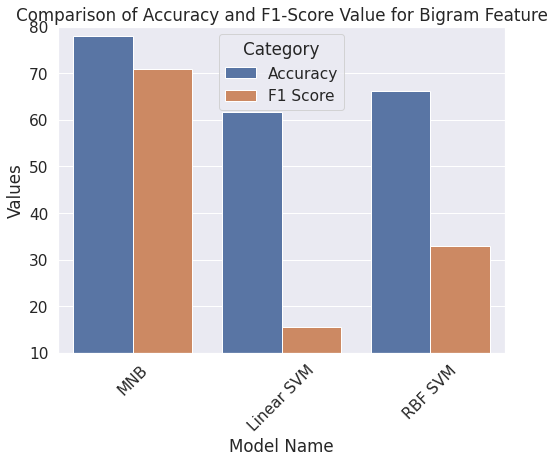

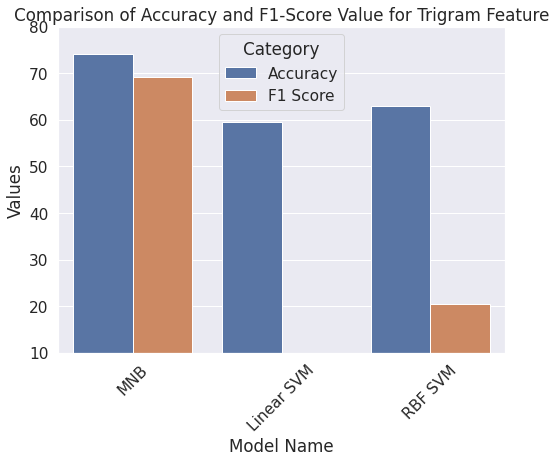

In [227]:
gram_names = ['Unigram','Bigram','Trigram']

for gram in gram_names:
    accuracy = json.load(open(path + f'ml_performance_{gram}.json'))
    table = performance_table(accuracy)
    df = pd.melt(table[['Accuracy', 'F1 Score', 'Model Name']],
                id_vars="Model Name", var_name="Category", value_name="Values")

    plt.figure(figsize=(8,6))
    ax = plt.subplot()
    sns.barplot(data=df, x='Model Name', y='Values', hue='Category')
    ax.set_xlabel('Model Name') 
    ax.set_title(f'Comparison of Accuracy and F1-Score Value for {gram} Feature')
    ax.set_ylim([10,80])
    ax.xaxis.set_ticklabels(table['Model Name'], rotation=45);